In [13]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv",index_col=0)

In [14]:
df_train = train_data.iloc[:, 0:102]
df_train.describe()


,label,basic_1,basic_2,basic_3,basic_4,basic_5,basic_6,basic_7,basic_8,basic_9,...,query_2,query_3,query_4,query_5,query_6,query_7,query_8,query_9,query_10,query_11
count,17999.000000,17999.00000,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000,17999.00000,17999.0,17999.0,...,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000,17999.000000
mean,0.033891,-83.13323,-63.085394,-19.020638,5.275127,0.566031,0.805156,40.16262,0.0,0.0,...,0.640480,-0.011001,0.246569,-0.643536,1.363187,1.362965,-0.302628,-0.643536,2.455692,0.003111
std,0.180953,36.63750,97.374722,332.683845,394.146047,9.457484,9.487904,7.79562,0.0,0.0,...,8.189033,8.059996,8.109108,7.956093,8.358311,8.324049,8.012508,7.956093,8.665412,8.066791
min,0.000000,-99.00000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,20.00000,0.0,0.0,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
25%,0.000000,-99.00000,-99.000000,-99.000000,-99.000000,1.000000,1.000000,34.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,-99.00000,-99.000000,-99.000000,-99.000000,1.000000,2.000000,40.00000,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,0.000000
75%,0.000000,-99.00000,-99.000000,-99.000000,-99.000000,2.000000,2.000000,46.00000,0.0,0.0,...,2.000000,1.000000,1.000000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,1.000000
max,1.000000,9.00000,1481.000000,7665.000000,7200.000000,7.000000,7.000000,60.00000,0.0,0.0,...,14.000000,15.000000,15.000000,0.000000,28.000000,16.000000,8.000000,0.000000,28.000000,12.000000


In [15]:
df_train.iloc[:, 3].value_counts()


-99.0000      15156
 0.0000        1434
 1000.0000       40
 500.0000        39
 600.0000        34
 300.0000        28
 200.0000        27
 1200.0000       27
 700.0000        25
 220.0000        23
 800.0000        21
 400.0000        21
 360.0000        20
 480.0000        20
 2000.0000       19
 720.0000        18
 1500.0000       16
 560.0000        16
 420.0000        14
 320.0000        13
 350.0000        11
 840.0000        11
 490.0000        10
 960.0000         9
 348.0000         9
 324.0000         9
 260.0000         9
 1400.0000        9
 180.0000         9
 1440.0000        8
              ...  
 3412.0000        1
 2600.0000        1
 7200.0000        1
 388.0000         1
 2025.0000        1
 1364.0000        1
 1330.0000        1
 110.0000         1
 648.0000         1
 378.0000         1
 794.0000         1
 5734.0000        1
 411.0000         1
 920.6667         1
 317.0000         1
 2146.0000        1
 568.0000         1
 520.0000         1
 1072.0000        1


In [16]:
for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts())

-99      15157
 121        30
 124        29
 115        29
 62         27
 110        27
 120        27
 118        24
 111        23
 108        23
 125        22
 98         22
 119        21
 94         21
 116        21
 122        21
 67         20
 45         20
 57         20
 43         20
 52         20
 88         20
 58         20
 123        20
 41         20
 114        19
 127        19
 107        19
 49         19
 72         19
         ...  
 317         1
 238         1
 270         1
 286         1
 318         1
 350         1
 366         1
 287         1
 234         1
 297         1
 281         1
 232         1
 354         1
 323         1
 339         1
 308         1
 324         1
 340         1
 1460        1
 1476        1
 325         1
 310         1
 326         1
 358         1
 1478        1
 215         1
 231         1
 327         1
 343         1
 279         1
Name: basic_2, Length: 344, dtype: int64
-99.0000      15156
 0.0000        1434
 100

In [17]:
full_col_name=list(df_train.columns)
num_col = ["basic_2",
           "basic_3",
           "basic_4",
           "basic_7",
           "basic_13"]
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14"]
drop_col = ["basic_8",
            "basic_9",
            "basic_11",
            "basic_15"]
loan_col=[i for i in full_col_name if "loan" in i]
overdue_col=[i for i in full_col_name if "overdue" in i]
query_col=[i for i in full_col_name if "query" in i]

x_col=num_col+type_col+loan_col+overdue_col+query_col


In [18]:
#df_train.drop(columns=drop_col)


In [19]:
from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.2
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed)


In [55]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 8,
    'eta': 0.2,
    'colsample_bytree':0.8,
    'objective': 'binary:logistic',
    #'scale_pos_weight':1,
    #'class_weight'
    #'eval_metric':'logloss'
}

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 200
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=3)


[0]	eval-logloss:0.53719	train-logloss:0.53604


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:571: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[1]	eval-logloss:0.43290	train-logloss:0.43035
[2]	eval-logloss:0.35889	train-logloss:0.35547
[3]	eval-logloss:0.30571	train-logloss:0.29941
[4]	eval-logloss:0.26603	train-logloss:0.25683
[5]	eval-logloss:0.23570	train-logloss:0.22448
[6]	eval-logloss:0.21265	train-logloss:0.19933
[7]	eval-logloss:0.19576	train-logloss:0.17867
[8]	eval-logloss:0.18256	train-logloss:0.16178
[9]	eval-logloss:0.17222	train-logloss:0.14896
[10]	eval-logloss:0.16442	train-logloss:0.13854
[11]	eval-logloss:0.15893	train-logloss:0.12947
[12]	eval-logloss:0.15412	train-logloss:0.12209
[13]	eval-logloss:0.15163	train-logloss:0.11452
[14]	eval-logloss:0.14915	train-logloss:0.10876
[15]	eval-logloss:0.14771	train-logloss:0.10377
[16]	eval-logloss:0.14677	train-logloss:0.09843
[17]	eval-logloss:0.14550	train-logloss:0.09298
[18]	eval-logloss:0.14476	train-logloss:0.08938
[19]	eval-logloss:0.14453	train-logloss:0.08619
[20]	eval-logloss:0.14422	train-logloss:0.08358
[21]	eval-logloss:0.14376	train-logloss:0.08015
[

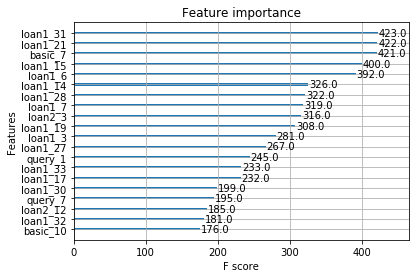

In [56]:

xgb.plot_importance(bst,max_num_features=20)


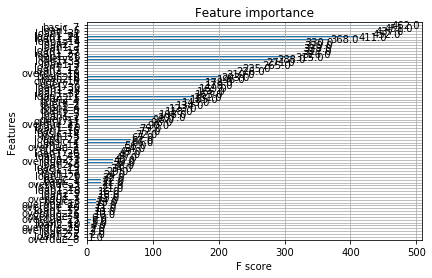

In [41]:
xgb.plot_importance(bst)


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

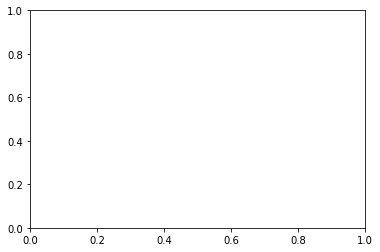

In [51]:
xgb.plot_tree(bst, num_trees=2)

In [53]:
import time

date=time.strftime("%Y%m%d", time.localtime())
df_test=pd.read_csv('data\main\df_test_b1.csv',index_col=0)
temp=xgb.DMatrix(df_test[x_col])
pred_label=list(bst.predict(temp))
#pred_label=[1 if i>=0.2 else 0 for i in pred_label]
res=pd.DataFrame({
    'cust_id':list(df_test.index),
    'label':pred_label,
})
res.to_csv("result"+date+".csv",encoding="utf-8",index=False)